### Piece Detection + Classification


In [25]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import src.detection as det
import src.svm_training as svm
from joblib import load

def detect_and_classify_pieces(img_path):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 480))
    img = img[10:-10, 5:-20]
    original = img.copy()
    # Show the original image
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Detect black and white pieces
    black_contours = det.detect_black_pieces(img)
    white_contours = det.detect_white_pieces(img)

    # Crop pieces using the crop_pieces function
    black_pieces = det.crop_pieces(img, black_contours, color='black')
    white_pieces = det.crop_pieces(img, white_contours, color='white')

    # Load the trained SVM and LDA models
    clf = load('model\\SVC_LDA.joblib')
    lda = load('model\\lda_transformer.joblib')

    # Function to classify pieces
    def classify_pieces(pieces, contours, color):
        for piece, contour in zip(pieces, contours):
            if piece is None or piece.size == 0:
                continue  # Skip invalid pieces
            x, y, w, h = cv2.boundingRect(contour)
            if color == 'black':
                padding_width = 0.25
                padding_height = 0.2
            else:
                padding_width = 0.25
                padding_height = 0.4
            features = svm.extract_features(piece)
            features_lda = lda.transform([features])
            label = clf.predict(features_lda)[0]
            extra_width = int(w * padding_width)
            extra_height = int(h * padding_height)
            x -= extra_width
            y -= extra_height
            w += extra_width
            h += extra_height
            cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(original, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 3)  # Black contour
            cv2.putText(original, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)  # White text

    # Classify and annotate black pieces
    classify_pieces(black_pieces, black_contours, color='black')

    # Classify and annotate white pieces
    classify_pieces(white_pieces, white_contours, color='white')

    # Display the original image with annotations
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### A few examples

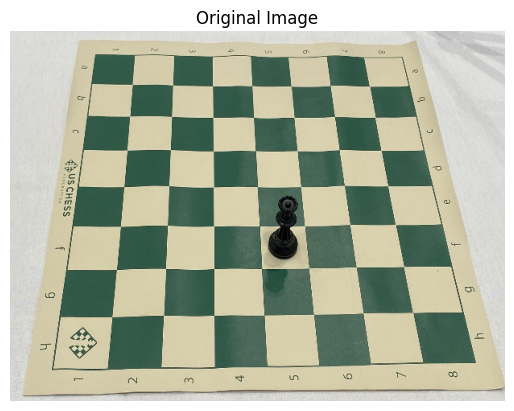

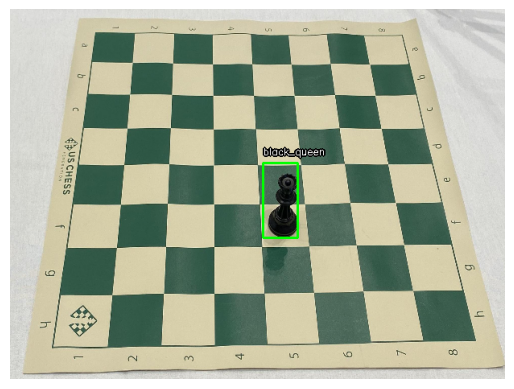

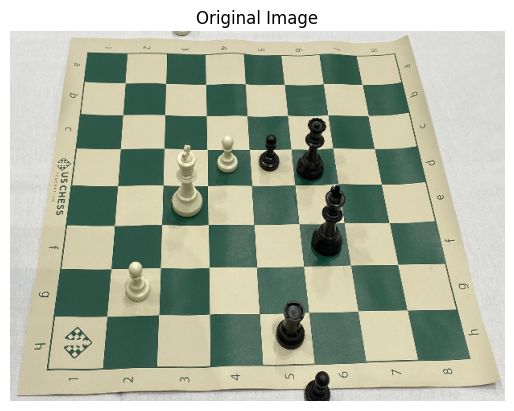

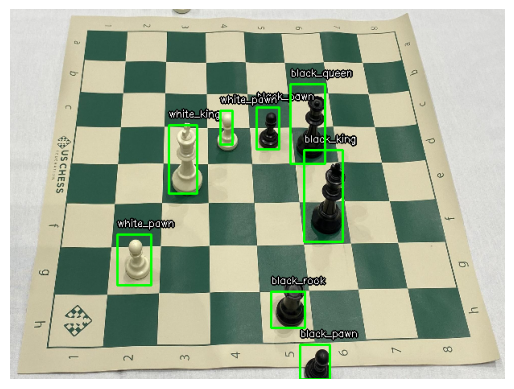

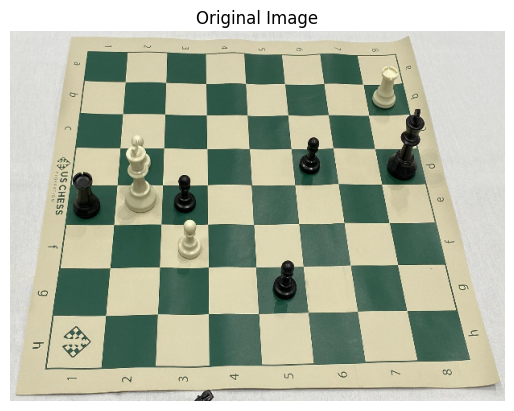

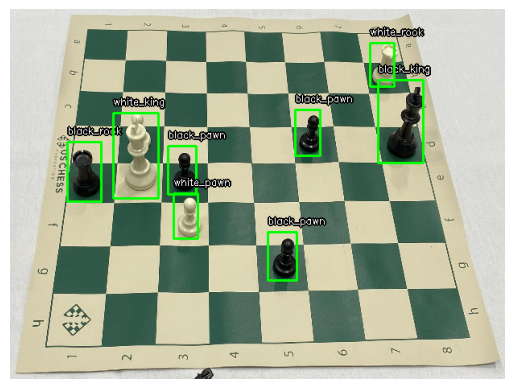

In [24]:
# Good examples
img_path = "data\\raw\\de60ba81aa78387928e4bdc11f3be301_jpg.rf.0cd8adb84fce0b83ee30a5fbdb4c1c4b.jpg"
detect_and_classify_pieces(img_path)
img_path = "data\\raw\\c0d68e012bb93c14bc333fc1d5e52621_jpg.rf.47fcf95dac60ca78902fc86cca7eab28.jpg"
detect_and_classify_pieces(img_path)
img_path = "data\\raw\\IMG_0297_JPG.rf.2609f7e3ad4d54b19aafc0623f5a8510.jpg"
detect_and_classify_pieces(img_path)


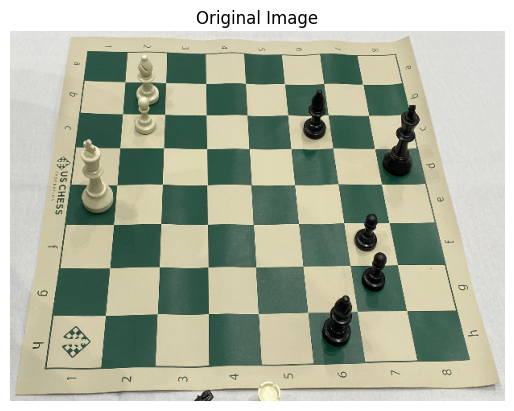

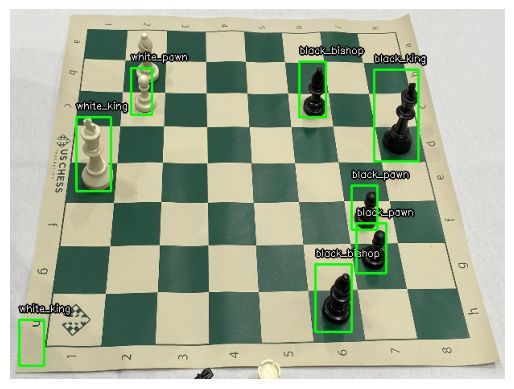

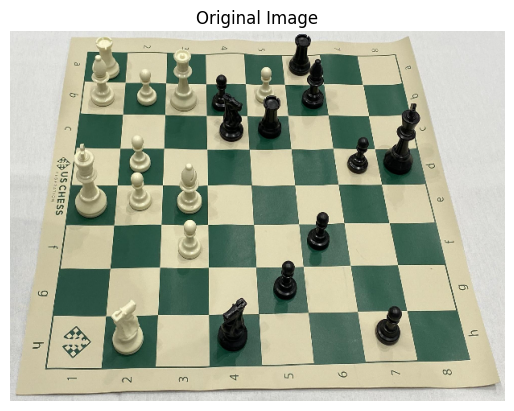

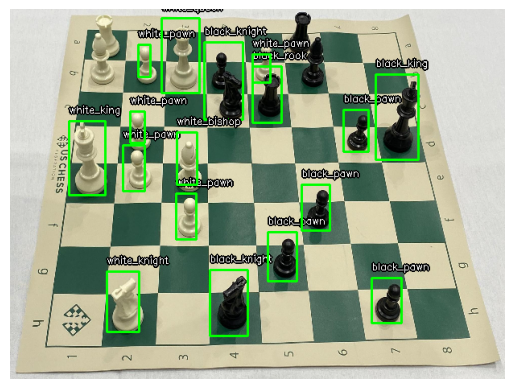

In [ ]:
# Challenging examples
img_path = "data\\raw\\8ec14357f5f18fb98db86e0283623150_jpg.rf.dc1f65d43628062fda98946db19045ef.jpg"
detect_and_classify_pieces(img_path)
img_path = "data\\raw\\f9a9a175f26d4b26bca3a5338cc1405e_jpg.rf.ec1a436f709ef7dc2e4f1fd3c9f6355e.jpg"
detect_and_classify_pieces(img_path)

### In-depth look at the detection pipeline

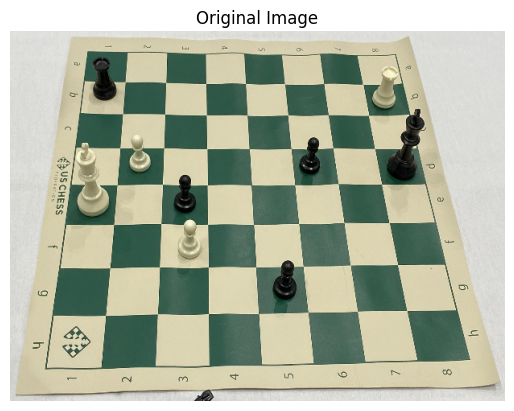

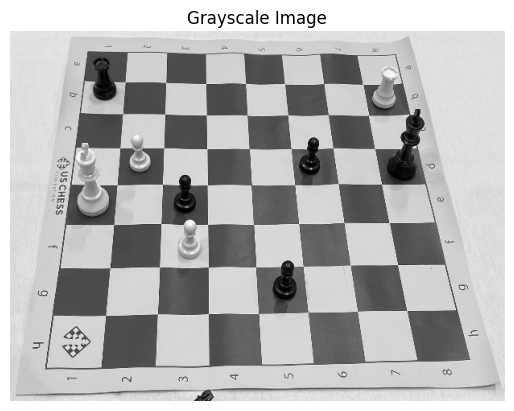

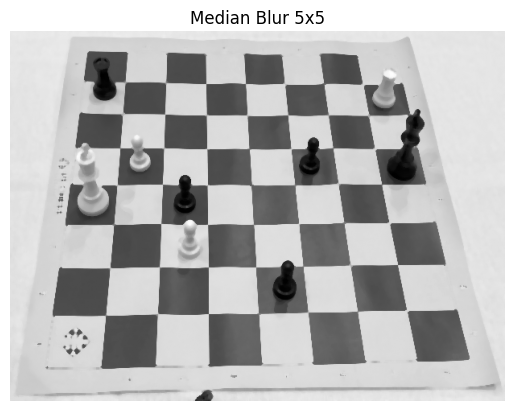

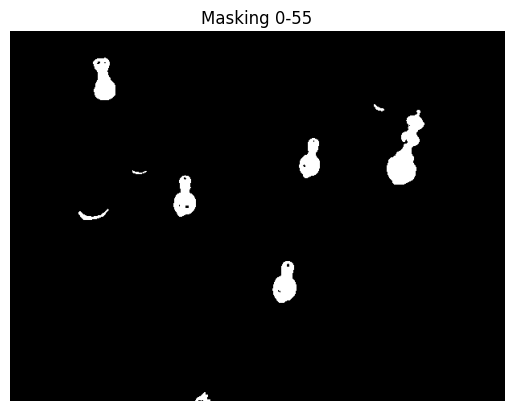

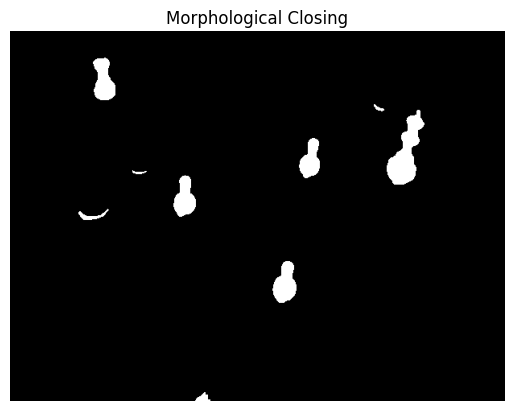

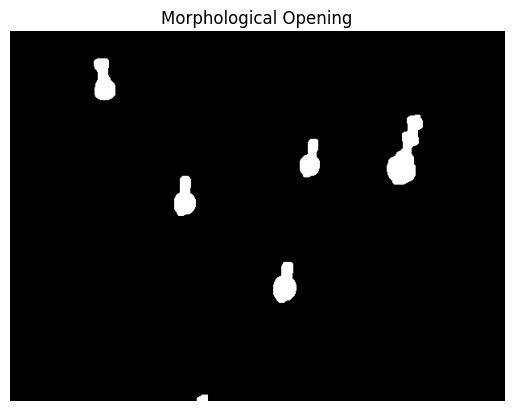

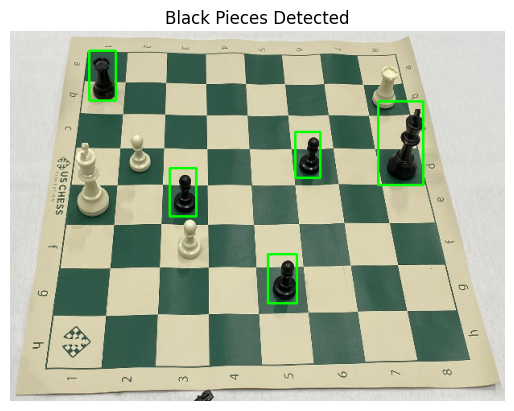

In [26]:
# Black pieces

def detect_black_pieces(img, threshold=55, min_area=150, max_area=2500):
    # Show the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap='gray')
    plt.axis('off')
    plt.title('Grayscale Image')
    plt.show()

    # Apply median blur
    img_blur = cv2.medianBlur(img_gray, 5)
    plt.imshow(img_blur, cmap='gray')
    plt.axis('off')
    plt.title('Median Blur 5x5')
    plt.show()

    # Apply threshold
    img_thresh = cv2.inRange(img_blur, 0, threshold)
    plt.imshow(img_thresh, cmap='gray')
    plt.axis('off')
    plt.title('Masking 0-55')
    plt.show()

    # Apply morphological operations to remove noise
    kernel = np.ones((7, 7), np.uint8)
    img_close = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)  # Close
    plt.imshow(img_close, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Closing')
    plt.show()

    img_open = cv2.morphologyEx(img_close, cv2.MORPH_OPEN, kernel)  # Open
    plt.imshow(img_open, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Opening')
    plt.show()

    # Find contours of detected pieces
    contours, _ = cv2.findContours(img_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and height/width ratio
    contours = [c for c in contours
                if max_area > cv2.contourArea(c) > min_area
                and cv2.boundingRect(c)[2] <= cv2.boundingRect(c)[3] <= 3 * cv2.boundingRect(c)[2]]

    return contours


# example
img_path = "data\\raw\\IMG_0295_JPG.rf.8abd802272b965c843eb1ecbc8df4abc.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
img = img[10:-10, 5:-20]
contours = detect_black_pieces(img)
img = det.draw_black_bounding_boxes(img, contours)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Black Pieces Detected')
plt.show()

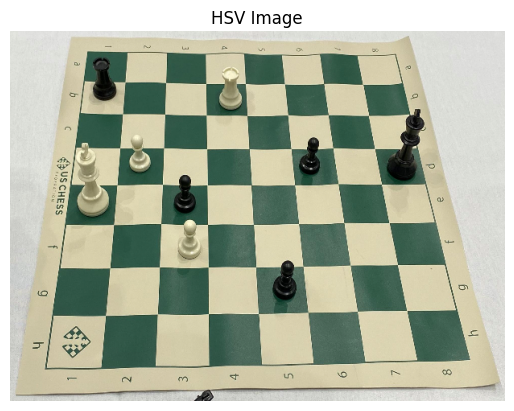

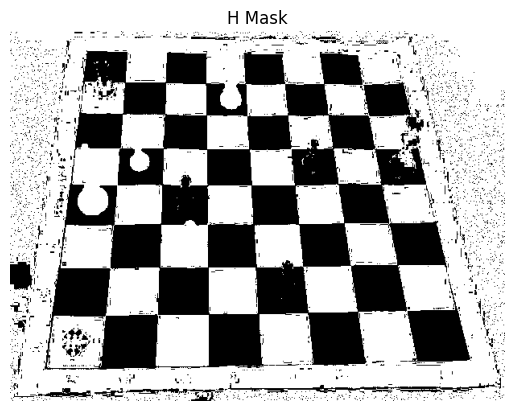

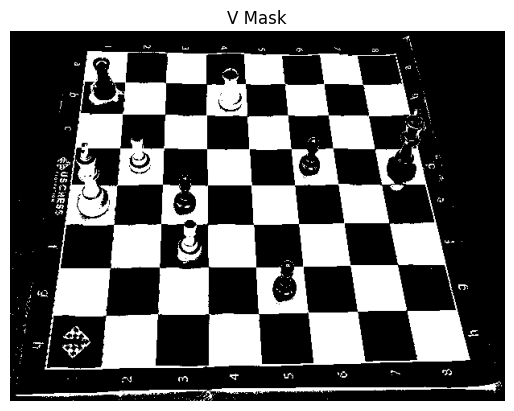

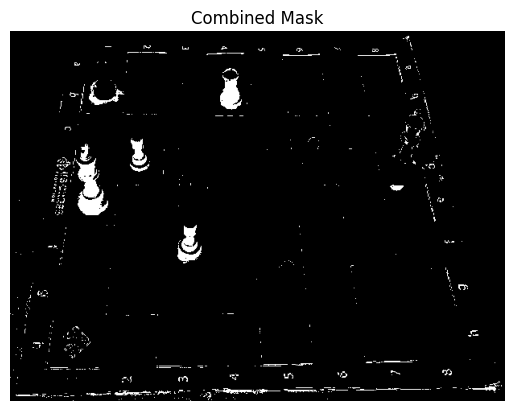

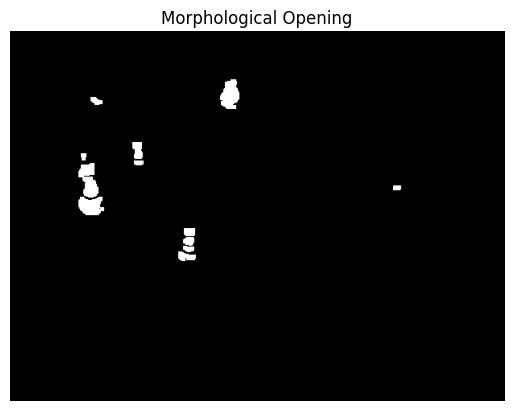

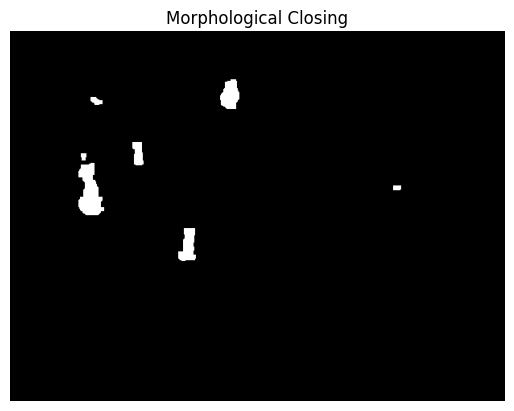

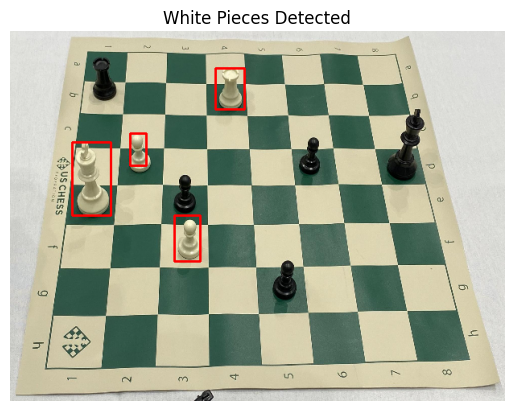

In [29]:
# White pieces

def detect_white_pieces(img, h_bounds=(23, 36), v_bounds=(64, 191), min_area=150, max_area=2500):
    # Convert to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
    plt.axis('off')
    plt.title('HSV Image')
    plt.show()

    # Split HSV channels and take only H and V
    h, _, v = cv2.split(img_hsv)

    # Apply threshold only on H and V channels
    h_mask = cv2.inRange(h, h_bounds[0], h_bounds[1])
    plt.imshow(h_mask, cmap='gray')
    plt.axis('off')
    plt.title('H Mask')
    plt.show()

    v_mask = cv2.inRange(v, v_bounds[0], v_bounds[1])
    plt.imshow(v_mask, cmap='gray')
    plt.axis('off')
    plt.title('V Mask')
    plt.show()

    # Combine masks
    mask = cv2.bitwise_and(h_mask, v_mask)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')
    plt.show()

    # Apply morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Open
    plt.imshow(mask_open, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Opening')
    plt.show()

    mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel)  # Close
    plt.imshow(mask_close, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Closing')
    plt.show()

    # Find contours of detected pieces
    contours, _ = cv2.findContours(mask_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    contours = [c for c in contours
                if max_area > cv2.contourArea(c) > min_area
                and cv2.boundingRect(c)[2] <= cv2.boundingRect(c)[3] <= 2.5 * cv2.boundingRect(c)[2]]

    return contours

# example
img_path = "data\\raw\\IMG_0294_JPG.rf.b7ae411904ff022e80b90f6267535f05.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
img = img[10:-10, 5:-20]
contours = detect_white_pieces(img)
img = det.draw_white_bounding_boxes(img, contours)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('White Pieces Detected')
plt.show()